<a href="https://colab.research.google.com/github/jbajaj1/faketweets/blob/master/faketweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.utils.data as data
import handleTwitterSent as TS
from torch.utils.data import TensorDataset, DataLoader

In [2]:
twitterVoc = TS.Vocab("twitter")

#Put proper location of file here
tokenizedTweets, tokenizedLabels = TS.load_tweets("../twitter_sentiment/semeval_train_trimmed.txt", Voc=twitterVoc, initVoc=True)

print(twitterVoc.to_word(4))
print(twitterVoc.to_index("this"))

print(twitterVoc.num_words)

so
244
22176


In [3]:
from os import listdir
from os.path import isfile, join

emb_list = [16, 32, 64, 128]
hid_list = [16, 32, 64]
num_layers = [1,2]
dropout = [0, .1, .3]

completed_models = [f for f in listdir("./models/") if isfile(join("./models/", f)) and ".model" in f]

##################
#####Training#####
##################
#(vocab_size, embedding_size, hidden_size, num_layers=2, dropout=0.1)
highPrec = (0, None, None, None)
results_prec = []
for emb in emb_list:
    for hid in hid_list:
        for l in num_layers:
            for d in dropout:
                ourLSTM = TS.LSTM(twitterVoc.num_words, emb, hid, l, d)      
                if f'http_and_user_{emb}_{hid}_{l}_{d}.model' not in completed_models:
                    print(f'Training http_and_user_{emb}_{hid}_{l}_{d}.model')
                    #print(f'{emb}_{hid}_{l}_{d}.model')
                    
                    opt = torch.optim.Adam(ourLSTM.parameters(), lr=.1)
                    loss = torch.nn.CrossEntropyLoss()
                    epochs = 30
                    dataset = DataLoader(TensorDataset(tokenizedTweets, tokenizedLabels), batch_size=100)
                    for i in range(epochs):
                        print("Training on epoch", i)
                        for batchidx, (x, y) in enumerate(dataset):
                            opt.zero_grad()
                            outputs = ourLSTM(x)
                            lossVal = loss(outputs, y)
                            lossVal.backward()
                            opt.step()
                    
                    torch.save(ourLSTM.state_dict(), f'./models/http_and_user_{emb}_{hid}_{l}_{d}.model')
                
                else:
                    ourLSTM = TS.LSTM(twitterVoc.num_words, emb, hid, l, d)      
                    
                    print(f'Loading http_and_user_{emb}_{hid}_{l}_{d}.model')
                    ourLSTM.load_state_dict(torch.load(f'./models/http_and_user_{emb}_{hid}_{l}_{d}.model'))
                    ourLSTM.eval()
                    print(f'Loaded http_and_user_{emb}_{hid}_{l}_{d}.model')
                
                
                
                ##################
                #####Predict######
                ####Evaluation####
                ##################
                
                file = "semeval_train_dev.txt"
                #file = "Twitter2016_raw.txt"
                tokTestTweets, tokTestLabels = TS.load_tweets("../twitter_sentiment/" + file, twitterVoc)
                with torch.no_grad():
                    predVal = ourLSTM(tokTestTweets).argmax(dim=-1)
                prec, conf, neg_F1, pos_F1, F1 = TS.validate(tokTestLabels, predVal)
                results_prec.append(f'Precision with emb_size[{emb}], hid_size[{hid}], layers[{l}], and dropout[{d}]: {prec}')
                if prec > highPrec[0]:
                    highPrec = (prec, conf, len(results_prec) - 1, f'./models/http_and_user_{emb}_{hid}_{l}_{d}.model', neg_F1, pos_F1, F1)
                    


Training http_and_user_16_16_1_0.model
Training on epoch 0
Training on epoch 1
Training on epoch 2
Training on epoch 3
Training on epoch 4
Training on epoch 5
Training on epoch 6
Training on epoch 7
Training on epoch 8
Training on epoch 9
Training on epoch 10
Training on epoch 11
Training on epoch 12
Training on epoch 13
Training on epoch 14
Training on epoch 15
Training on epoch 16
Training on epoch 17
Training on epoch 18
Training on epoch 19
Training on epoch 20
Training on epoch 21
Training on epoch 22
Training on epoch 23
Training on epoch 24
Training on epoch 25
Training on epoch 26
Training on epoch 27
Training on epoch 28
Training on epoch 29
Training http_and_user_16_16_1_0.1.model
Training on epoch 0
Training on epoch 1
Training on epoch 2
Training on epoch 3
Training on epoch 4
Training on epoch 5
Training on epoch 6
Training on epoch 7
Training on epoch 8
Training on epoch 9
Training on epoch 10
Training on epoch 11
Training on epoch 12
Training on epoch 13
Training on epoc

Training on epoch 12
Training on epoch 13
Training on epoch 14
Training on epoch 15
Training on epoch 16
Training on epoch 17
Training on epoch 18
Training on epoch 19
Training on epoch 20
Training on epoch 21
Training on epoch 22
Training on epoch 23
Training on epoch 24
Training on epoch 25
Training on epoch 26
Training on epoch 27
Training on epoch 28
Training on epoch 29
Training http_and_user_16_64_1_0.1.model
Training on epoch 0
Training on epoch 1
Training on epoch 2
Training on epoch 3
Training on epoch 4
Training on epoch 5
Training on epoch 6
Training on epoch 7
Training on epoch 8
Training on epoch 9
Training on epoch 10
Training on epoch 11
Training on epoch 12
Training on epoch 13
Training on epoch 14
Training on epoch 15
Training on epoch 16
Training on epoch 17
Training on epoch 18
Training on epoch 19
Training on epoch 20
Training on epoch 21
Training on epoch 22
Training on epoch 23
Training on epoch 24
Training on epoch 25
Training on epoch 26
Training on epoch 27
Tra

Training on epoch 25
Training on epoch 26
Training on epoch 27
Training on epoch 28
Training on epoch 29
Training http_and_user_32_32_1_0.1.model
Training on epoch 0
Training on epoch 1
Training on epoch 2
Training on epoch 3
Training on epoch 4
Training on epoch 5
Training on epoch 6
Training on epoch 7
Training on epoch 8
Training on epoch 9
Training on epoch 10
Training on epoch 11
Training on epoch 12
Training on epoch 13
Training on epoch 14
Training on epoch 15
Training on epoch 16
Training on epoch 17
Training on epoch 18
Training on epoch 19
Training on epoch 20
Training on epoch 21
Training on epoch 22
Training on epoch 23
Training on epoch 24
Training on epoch 25
Training on epoch 26
Training on epoch 27
Training on epoch 28
Training on epoch 29
Training http_and_user_32_32_1_0.3.model
Training on epoch 0
Training on epoch 1
Training on epoch 2
Training on epoch 3
Training on epoch 4
Training on epoch 5
Training on epoch 6
Training on epoch 7
Training on epoch 8
Training on e

Training on epoch 7
Training on epoch 8
Training on epoch 9
Training on epoch 10
Training on epoch 11
Training on epoch 12
Training on epoch 13
Training on epoch 14
Training on epoch 15
Training on epoch 16
Training on epoch 17
Training on epoch 18
Training on epoch 19
Training on epoch 20
Training on epoch 21
Training on epoch 22
Training on epoch 23
Training on epoch 24
Training on epoch 25
Training on epoch 26
Training on epoch 27
Training on epoch 28
Training on epoch 29
Training http_and_user_64_16_1_0.3.model
Training on epoch 0
Training on epoch 1
Training on epoch 2
Training on epoch 3
Training on epoch 4
Training on epoch 5
Training on epoch 6
Training on epoch 7
Training on epoch 8
Training on epoch 9
Training on epoch 10
Training on epoch 11
Training on epoch 12
Training on epoch 13
Training on epoch 14
Training on epoch 15
Training on epoch 16
Training on epoch 17
Training on epoch 18
Training on epoch 19
Training on epoch 20
Training on epoch 21
Training on epoch 22
Traini

Training on epoch 20
Training on epoch 21
Training on epoch 22
Training on epoch 23
Training on epoch 24
Training on epoch 25
Training on epoch 26
Training on epoch 27
Training on epoch 28
Training on epoch 29
Training http_and_user_64_64_1_0.3.model
Training on epoch 0
Training on epoch 1
Training on epoch 2
Training on epoch 3
Training on epoch 4
Training on epoch 5
Training on epoch 6
Training on epoch 7
Training on epoch 8
Training on epoch 9
Training on epoch 10
Training on epoch 11
Training on epoch 12
Training on epoch 13
Training on epoch 14
Training on epoch 15
Training on epoch 16
Training on epoch 17
Training on epoch 18
Training on epoch 19
Training on epoch 20
Training on epoch 21
Training on epoch 22
Training on epoch 23
Training on epoch 24
Training on epoch 25
Training on epoch 26
Training on epoch 27
Training on epoch 28
Training on epoch 29
Training http_and_user_64_64_2_0.model
Training on epoch 0
Training on epoch 1
Training on epoch 2
Training on epoch 3
Training o

Training on epoch 1
Training on epoch 2
Training on epoch 3
Training on epoch 4
Training on epoch 5
Training on epoch 6
Training on epoch 7
Training on epoch 8
Training on epoch 9
Training on epoch 10
Training on epoch 11
Training on epoch 12
Training on epoch 13
Training on epoch 14
Training on epoch 15
Training on epoch 16
Training on epoch 17
Training on epoch 18
Training on epoch 19
Training on epoch 20
Training on epoch 21
Training on epoch 22
Training on epoch 23
Training on epoch 24
Training on epoch 25
Training on epoch 26
Training on epoch 27
Training on epoch 28
Training on epoch 29
Training http_and_user_128_32_2_0.model
Training on epoch 0
Training on epoch 1
Training on epoch 2
Training on epoch 3
Training on epoch 4
Training on epoch 5
Training on epoch 6
Training on epoch 7
Training on epoch 8
Training on epoch 9
Training on epoch 10
Training on epoch 11
Training on epoch 12
Training on epoch 13
Training on epoch 14
Training on epoch 15
Training on epoch 16
Training on e

Precision with emb_size[16], hid_size[16], layers[1], and dropout[0]: 0.5745834947694692
Precision with emb_size[16], hid_size[16], layers[1], and dropout[0.1]: 0.578845408756296
Precision with emb_size[16], hid_size[16], layers[1], and dropout[0.3]: 0.48663308795040683
Precision with emb_size[16], hid_size[16], layers[2], and dropout[0]: 0.5710964742347927
Precision with emb_size[16], hid_size[16], layers[2], and dropout[0.1]: 0.5769081751259202
Precision with emb_size[16], hid_size[16], layers[2], and dropout[0.3]: 0.5610228593568385
Precision with emb_size[16], hid_size[32], layers[1], and dropout[0]: 0.5350639287098023
Precision with emb_size[16], hid_size[32], layers[1], and dropout[0.1]: 0.5679969004261914
Precision with emb_size[16], hid_size[32], layers[1], and dropout[0.3]: 0.562185199535064
Precision with emb_size[16], hid_size[32], layers[2], and dropout[0]: 0.5211158465710964
Precision with emb_size[16], hid_size[32], layers[2], and dropout[0.1]: 0.47268500581170086
Precisi

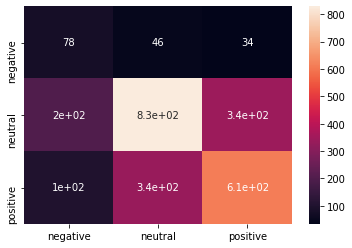

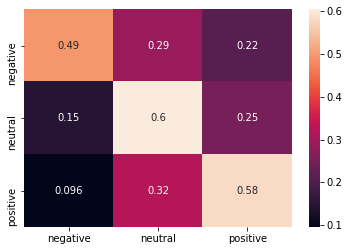

In [4]:
for r in results_prec:
    print(r)
print(f'The best performer:\n{results_prec[highPrec[2]]}\nF1: {highPrec[6]}\nNegF1: {highPrec[4]}\nPosF1: {highPrec[5]}\nHere are the heatmaps\n')

import seaborn as sn
from matplotlib import pyplot as plt

%matplotlib inline

conf = highPrec[1].T
#Counts graph
sn.heatmap(conf, annot=True, xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
plt.show()
#Percentages graph
sn.heatmap(conf/conf.sum(1, keepdims=True), annot=True, xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
plt.show()


In [5]:


print("Num Unknown Words:", twitterVoc.unknown_count)


Num Unknown Words: 470016


In [10]:
import bow_baseline as BoW

trainX_bow, trainY_bow = BoW.load_data('../twitter_sentiment/semeval_train_trimmed.txt')
testX_bow, testY_bow= BoW.load_data('../twitter_sentiment/semeval_train_dev.txt')
#testX_bow, testY_bow= BoW.load_data('../twitter_sentiment/Twitter2016_raw.txt')

classifier = BoW.Classifier()

classifier.train(trainX_bow, trainY_bow)
outputs = classifier.classify(testX_bow)


prec_bow, conf_bow, neg_F1_bow, pos_F1_bow, F1_bow = BoW.validate(outputs, testY_bow)

print(f'Accuracy: {prec_bow}\nF1: {F1_bow}\nneg_F1: {neg_F1_bow}\npos_F1: {pos_F1_bow}')


Accuracy: 0.47500968616815187
F1: 0.46856017885836465
neg_F1: 0.33363390441839497
pos_F1: 0.4209245742092457


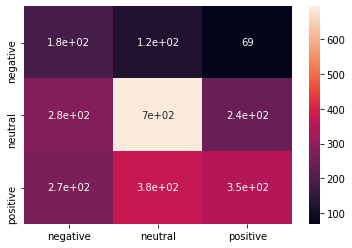

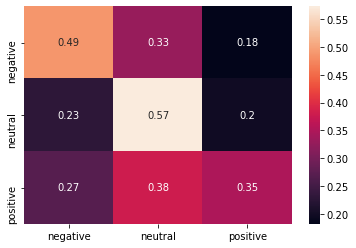

In [7]:
conf_bow = conf_bow.T
#Counts graph
sn.heatmap(conf_bow, annot=True, xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
plt.show()
#Percentages graph
sn.heatmap(conf_bow/conf_bow.sum(1, keepdims=True), annot=True, xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
plt.show()

In [8]:

lstm_model_values = [highPrec[0], highPrec[6], highPrec[4], highPrec[5]]
bow_model_values = [prec_bow, F1_bow, neg_F1_bow, pos_F1_bow]
x_score_tics = ['Accuracy', 'F1', 'Neg_F1', 'Pos_F1']
y_score_tics = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
print(f'Model: [Accuracy, F1, Neg_F1, Pos_F1]\nLSTM_Values: {lstm_model_values}\nBaseline BoW_Values: {bow_model_values}')

Model: [Accuracy, F1, Neg_F1, Pos_F1]
LSTM_Values: [0.5885315769081751, 0.5740061383153453, 0.2905027932960894, 0.6]
Baseline BoW_Values: [0.47500968616815187, 0.46856017885836465, 0.33363390441839497, 0.4209245742092457]


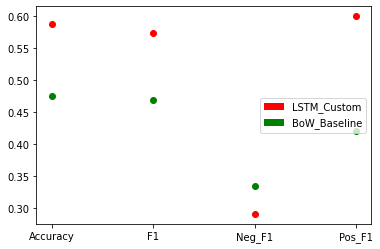

In [9]:
plt.scatter(x_score_tics, lstm_model_values, c='r')
plt.scatter(x_score_tics, bow_model_values, c='g')
import matplotlib.patches as mpatches
classes = ['LSTM_Custom','BoW_Baseline']
class_colors = ['r', 'g']
recs = []
for i in range(0,len(class_colors)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colors[i]))
plt.legend(recs,classes,loc=5)
plt.show()